In [2]:
%matplotlib inline
%autosave 0

import numpy as np
from scipy.io import loadmat
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import warnings
import time

Autosave disabled


In [3]:
data = loadmat("ex3data1.mat",
       matlab_compatible = True)

print(data.keys())
data['X'].shape

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])


(5000, 400)

Matlab version had '0's coded as '10' because Matlab has no index 0. Can relabel 0's as 0's for the Python version.

In [4]:
print(np.unique(data['y']))
data['y'][data['y'] == 10] = 0
print(np.unique(data['y']))

[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.]
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9.]


# Visualize dataset

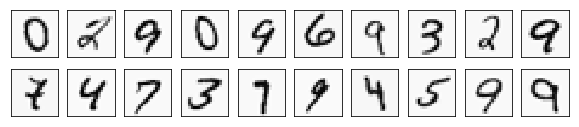

In [225]:
plt.figure(figsize=(10, 2))
counter = 1
for digit in np.random.choice(range(5000), 20, replace = False):
    plt.subplot(2, 10, counter)
    sub = data['X'][digit].reshape((20, 20), order = 'F')
    plt.imshow(sub, cmap = 'Greys')
    plt.xticks(())
    plt.yticks(())
    counter +=1

### All 5000 images superimposed

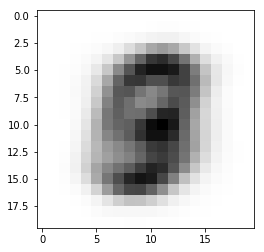

In [9]:
sub = np.sum(data['X'], axis = 0).reshape((20, 20), order = 'F')
plt.imshow(sub, cmap = 'Greys')

### All images with a specific digit superimposed

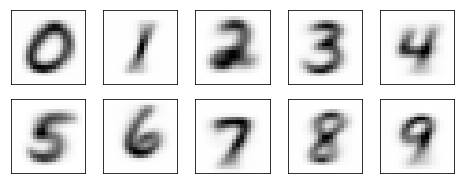

In [203]:
plt.figure(figsize=(8, 3))

for digit in range(10):    
    plt.subplot(2, 5, digit + 1)
    sub1 = data['X'][(data['y'] == digit).flatten(),:]
    sub = np.sum(sub1, axis = 0).reshape((20, 20), order = 'F')
    plt.imshow(sub, cmap = 'Greys')
    plt.xticks(())
    plt.yticks(()) 

Images are quite well alligned and scaled. Surprisingly, the superimposed images do not appear to be very noisy: this could explain why the accuracy of even a simple logistic regression is so high (below).

### Crop images
There is a lot of white space around the digits: this suggests that the images can be cropped, which may improve the time required to minimize the cost functions.

Checked, but cropping images did not really reduce training time... Some digits took quite long to train in the 15x15 images, and the total difference in time to the 20x20 images was relatively small.

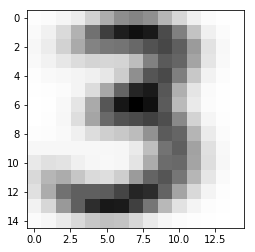

In [198]:
# crop images
mask = np.arange(400)
mask = mask.reshape((20, 20), order = 'F')
mask = mask[3:18, 3:18]
mask = mask.flatten(order = 'F')

masked = data['X'][:,mask]

sub1 = masked[(data['y'] == 3).flatten(order = 'F'),:]
sub = np.sum(sub1, axis = 0).reshape((15, 15), order = 'F')
plt.imshow(sub, cmap = 'Greys')

# Cost function

In [42]:
def sigmoid(z):
    '''returns sigmoid'''
    return(1 / (1 + np.exp(-z)))

In [43]:
def lrCostFunction(theta, X, y, lamb):
    '''Logistic cost function. Returns tuple (J, gradient)'''

    J = 0
    m = len(y)
    
    unregJ = np.sum(-y.T * np.log(sigmoid(np.dot(theta.T, X.T))) -\
                 (1-y.T) * np.log(1 - sigmoid(np.dot(theta.T, X.T)))) / m
              
    reg = (lamb * sum(theta[1:]**2)) / (2 * m)
    
    J = unregJ + reg
    
    return(J)

# test
if True:
    theta_t = np.array([-2, -1, 1, 2])
    temp = np.array(range(1,16)).reshape(5,3, order = 'F')
    X_t = np.hstack((np.ones(5).reshape(5,1), temp/10))
    y_t = np.array([1, 0, 1, 0, 1]).reshape(5,1)
    lamb_t = 3

    print(lrCostFunction(theta_t, X_t, y_t, lamb_t))

2.53481939611


In [44]:
def lrGradient(theta, X, y, lamb):
    '''Logistic cost function gradient'''

    grad = np.zeros(theta.shape)
    m = len(y)
    
    grad[0] = (np.dot((sigmoid(np.dot(theta.T, X.T)) - y.T), X[:,0].T)) / m
    grad[1:] = (np.dot((sigmoid(np.dot(theta.T, X.T)) - y.T), X[:,1:])) / m + lamb*theta[1:] / m
    
    return(grad)

# test
if True:
    theta_t = np.array([-2, -1, 1, 2])
    temp = np.array(range(1,16)).reshape(5,3, order = 'F')
    X_t = np.hstack((np.ones(5).reshape(5,1), temp/10))
    y_t = np.array([1, 0, 1, 0, 1]).reshape(5,1)
    lamb_t = 3

    print(lrGradient(theta_t, X_t, y_t, lamb_t))

[ 0.14656137 -0.54855841  0.72472227  1.39800296]


In [81]:
def oneVsAll(X, y, num_labels, lamb, min_method = 'TNC', jac = lrGradient, *args):
    '''Trains neural network. Using TNC minimization, but Newton-CG is better (but slower)'''
        
    m = X.shape[0] # size training set
    n = X.shape[1] # pixels (400)
    all_theta = np.zeros((num_labels, n + 1))
    
    # add ones to the data X
    X = np.hstack((np.ones(m).reshape(m,1), X))
        
    #Set initial theta
    initial_theta = np.zeros(n + 1)#.reshape((n + 1, 1))

    
    start = time.time()

    for row in range(num_labels):
        

        print('Minimizing row {0} of {1}...'.format(row + 1, num_labels), end="")

        theta = minimize(lrCostFunction,
                x0 = initial_theta,
                args = (X, y == row, lamb),
                method = min_method,
                jac = jac)
        
        all_theta[row,:] = theta.x
        
        print(' Time elapsed: {0:.2f} seconds.\n   Cost J = {1:.2e}'.format(time.time() - start,
                                                       lrCostFunction(theta.x, X, y == row, lamb)))


    print('Done.')

    return(all_theta)

In [46]:
def predictOneVsAll(X, all_theta):

    m = X.shape[0]
    num_labels = all_theta.shape[0]

    p = np.zeros(m)
    
    # add ones to the data X
    X = np.hstack((np.ones(m).reshape(m,1), X))

    for k in range(m):
        pall = sigmoid(np.dot(all_theta, X[k,:].T))
        I = np.argmax(pall)
        p[k] = I

    return(p.reshape(m, 1))

In [150]:
def stats(predict, correct):
    
    length = predict.shape[0]    
    total_correct = sum(sum(predict == correct))
    accuracy = total_correct / length
    print('Accuracy = {0:.2f}%'.format(accuracy * 100))
    return(accuracy)

In [49]:
# set parameters
input_layer_size  = 400
num_labels = 10

with warnings.catch_warnings():
    warnings.simplefilter("ignore") # there was a warning when running the minimize function
    
    all_theta = oneVsAll(data['X'], data['y'],
                         num_labels, lamb = 1,
                         min_method = 'Newton-CG')

    predictions = predictOneVsAll(data['X'], all_theta)
    stats(predictions, data['y'])

Minimizing row 1 of 10... Time elapsed: 2.20 seconds.
   Cost J = -9.05e+00
Minimizing row 2 of 10... Time elapsed: 3.09 seconds.
   Cost J = -1.13e+01
Minimizing row 3 of 10... Time elapsed: 3.95 seconds.
   Cost J = -6.46e+00
Minimizing row 4 of 10... Time elapsed: 4.69 seconds.
   Cost J = -6.71e+00
Minimizing row 5 of 10... Time elapsed: 5.44 seconds.
   Cost J = -8.05e+00
Minimizing row 6 of 10... Time elapsed: 6.09 seconds.
   Cost J = -6.33e+00
Minimizing row 7 of 10... Time elapsed: 6.86 seconds.
   Cost J = -8.47e+00
Minimizing row 8 of 10... Time elapsed: 64.79 seconds.
   Cost J = -8.74e+00
Minimizing row 9 of 10... Time elapsed: 67.47 seconds.
   Cost J = -5.62e+00
Minimizing row 10 of 10... Time elapsed: 128.59 seconds.
   Cost J = -6.75e+00
Done.
Accuracy = 94.44%


Newton-CG method appears to be the best method to use. Accuracy is 94.44%, while the fmincg algorithm used in Matlab gave an accuracy of 94.9%. Other methods (such as TNC, BFGS) gave accuracies of just over 70%. Keep in mind that these accuracies are being calculated in the training set.

### Testing the model

Split the dataset into train and test dataset.

In [144]:
# random shuffle of the 5000 data point (index)
mix = np.random.choice(range(5000), 5000, replace = False)

# pick 4000 data points (using shuffled index) for the train set
X_train = data['X'][mix[:4000],:]
y_train = data['y'][mix[:4000],:]

# pick the remaining data points for the test set
X_test = data['X'][mix[4000:],:]
y_test = data['y'][mix[4000:],:]

In [181]:
# set parameters
input_layer_size  = 400
num_labels = 10

with warnings.catch_warnings():
    warnings.simplefilter("ignore") # there was a warning when running the minimize function
    
    all_theta = oneVsAll(X_train, y_train,
                         num_labels, lamb = 1,
                         min_method = 'Newton-CG')

    predictions = predictOneVsAll(X_test, all_theta)

    
    stats(predictions, y_test)

Minimizing row 1 of 10... Time elapsed: 2.26 seconds.
   Cost J = -8.61e+00
Minimizing row 2 of 10... Time elapsed: 3.71 seconds.
   Cost J = -1.11e+01
Minimizing row 3 of 10... Time elapsed: 5.03 seconds.
   Cost J = -6.45e+00
Minimizing row 4 of 10... Time elapsed: 79.56 seconds.
   Cost J = -6.55e+00
Minimizing row 5 of 10... Time elapsed: 81.63 seconds.
   Cost J = -8.43e+00
Minimizing row 6 of 10... Time elapsed: 82.81 seconds.
   Cost J = -6.38e+00
Minimizing row 7 of 10... Time elapsed: 84.26 seconds.
   Cost J = -8.05e+00
Minimizing row 8 of 10... Time elapsed: 85.64 seconds.
   Cost J = -8.42e+00
Minimizing row 9 of 10... Time elapsed: 87.53 seconds.
   Cost J = -5.65e+00
Minimizing row 10 of 10... Time elapsed: 203.29 seconds.
   Cost J = -6.88e+00
Done.
Accuracy = 89.50%


In [168]:
if False: # takes a very long time to run
    # set parameters
    input_layer_size  = 400
    num_labels = 10# try different regularization parameters

    accu = []

    with warnings.catch_warnings():
        warnings.simplefilter("ignore") # there was a warning when running the minimize function

        for lamb in [0] + [3**x for x in range(-5, 5)]:
            print('\n***** testing lambda {0}*****'.format(lamb))

            all_theta = oneVsAll(X_train, y_train,
                                 num_labels, lamb = lamb,
                                 min_method = 'Newton-CG')

            predictions = predictOneVsAll(X_test, all_theta)
            accu.append(stats(predictions, y_test))


***** testing lambda 0*****
Minimizing row 1 of 10... Time elapsed: 122.05 seconds.
   Cost J = nan
Minimizing row 2 of 10... Time elapsed: 123.11 seconds.
   Cost J = -1.03e+01
Minimizing row 3 of 10... Time elapsed: 263.36 seconds.
   Cost J = nan
Minimizing row 4 of 10... Time elapsed: 714.90 seconds.
   Cost J = nan
Minimizing row 5 of 10... Time elapsed: 837.15 seconds.
   Cost J = nan
Minimizing row 6 of 10... Time elapsed: 1280.39 seconds.
   Cost J = nan
Minimizing row 7 of 10... Time elapsed: 1399.41 seconds.
   Cost J = nan
Minimizing row 8 of 10... Time elapsed: 1526.17 seconds.
   Cost J = nan
Minimizing row 9 of 10... Time elapsed: 1670.87 seconds.
   Cost J = -1.54e+01
Minimizing row 10 of 10... Time elapsed: 1688.55 seconds.
   Cost J = -2.34e+01
Done.
Accuracy = 84.70%

***** testing lambda 0.00411522633744856*****
Minimizing row 1 of 10... Time elapsed: 5.48 seconds.
   Cost J = nan
Minimizing row 2 of 10... Time elapsed: 11.71 seconds.
   Cost J = -3.67e+01
Minimizin

Minimizing row 1 of 10... Time elapsed: 0.83 seconds.
   Cost J = -3.96e+00
Minimizing row 2 of 10... Time elapsed: 1.11 seconds.
   Cost J = -4.36e+00
Minimizing row 3 of 10... Time elapsed: 2.03 seconds.
   Cost J = -3.27e+00
Minimizing row 4 of 10... Time elapsed: 2.88 seconds.
   Cost J = -3.40e+00
Minimizing row 5 of 10... Time elapsed: 3.31 seconds.
   Cost J = -3.53e+00
Minimizing row 6 of 10... Time elapsed: 3.79 seconds.
   Cost J = -2.99e+00
Minimizing row 7 of 10... Time elapsed: 4.14 seconds.
   Cost J = -3.62e+00
Minimizing row 8 of 10... Time elapsed: 4.53 seconds.
   Cost J = -3.63e+00
Minimizing row 9 of 10... Time elapsed: 5.69 seconds.
   Cost J = -3.03e+00
Minimizing row 10 of 10... Time elapsed: 6.56 seconds.
   Cost J = -3.20e+00
Done.
Accuracy = 86.80%


Took long time to run. Results (accu) were:
[0.84699999999999998,
 0.877,
 0.878,
 0.88600000000000001,
 0.89200000000000002,
 0.89400000000000002,
 0.89500000000000002,
 0.89100000000000001,
 0.88800000000000001,
 0.88200000000000001,
 0.86799999999999999]
 
 So the best lambda parameter was 1 -> 89.5% accuracy

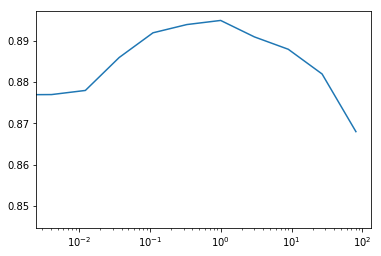

In [173]:
plt.plot([0] + [3**x for x in range(-5, 5)], accu)
plt.xscale('log')

# Visualize predictions

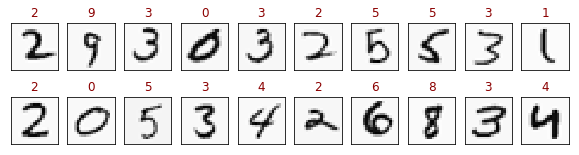

In [283]:
ix, temp = np.where(predictions == y_test)

plt.figure(figsize=(10, 2.5))
counter = 1
for samp in np.random.choice(ix, 20, replace = False):
    plt.subplot(2, 10, counter)
    sub = X_test[samp].reshape((20, 20), order = 'F')
    plt.imshow(sub, cmap = 'Greys')
    plt.title(int(predictions[samp]), color = 'darkred')
    plt.xticks(())
    plt.yticks(())
    counter +=1